In [1]:
import pandas as pd
import util
gt_df = util.DataExtractor().croppedData()

Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [ ]:
gt_df.head()
#config.img_dir contains the files
#config.S describes the SxS grid of cx anad cy. tx, ty are the positions within cells
# config.ANCHORS[0] contains the width and height of bounding boxes. the rendered bounding boxes are calculated as
#width = config.ANCHORS[0][0] * exp(tw) and height vice versa: height = config.ANCHORS[0][1] * exp(th) 
# this width and height is normalized to width and height of the image resolution, that you have to obtain from the loaded image. e.g. if
# the bounding boxes width is 100px and the image has a width of 2000px, the calculated width via formula above would be 0.05
#write a function that takes the gt_df and img_id as input and renders the image with bounding boxes on top.

,img_id,crop_id,cx_loc,cy_loc,tx,ty,tw,th,class_id,filename,cx,cy,crop_row,crop_col
0,679,2,8,5,0.000000,0.617912,3.772461,0.249753,134,lg-877777775968732096-aug-gonville--page-3.png,56,5,0,2
1,679,2,8,11,0.000000,0.154405,3.772461,0.249753,134,lg-877777775968732096-aug-gonville--page-3.png,56,11,0,2
2,679,3,15,18,0.328671,0.319279,-0.489309,-2.856328,1,lg-877777775968732096-aug-gonville--page-3.png,87,18,0,3
3,679,3,15,18,0.397779,0.856644,-0.591092,-3.261793,1,lg-877777775968732096-aug-gonville--page-3.png,87,18,0,3
4,679,3,12,18,0.863842,0.319279,-0.522099,-2.856328,1,lg-877777775968732096-aug-gonville--page-3.png,84,18,0,3


In [9]:
import math
from pathlib import Path
from typing import Union, Sequence
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def draw_gt_image(
    gt_df: pd.DataFrame,
    img_id: Union[int, str],
    config,
    anchor_set: int = 0,
    class_colors: dict = None,
    outline_width: int = 2,
    show: bool = True,
    save_path: Union[str, Path, None] = None,
    font: ImageFont.ImageFont = None
):
    """
    Render ground‑truth boxes for a given img_id.

    Assumptions (per your description):
      - Grid size: config.S = (Sx, Sy)  (cells along x (width), y (height))
      - For each row: (cx, cy) are integer cell indices in global SxSy grid.
      - tx, ty are *normalized* offsets inside the cell in [0,1].
      - tw, th are log-space deltas: w = anchor_w * exp(tw), h = anchor_h * exp(th)
      - anchor dims (config.ANCHORS[anchor_set]) are in *pixels*.
      - After computing pixel w,h we normalize by image size if needed; for drawing we keep pixel units.
    """
    # Filter rows
    rows = gt_df[gt_df['img_id'] == img_id]
    if rows.empty:
        raise ValueError(f"No rows for img_id={img_id}")

    # Load image
    img_file = rows.iloc[0]['filename']
    img_path = Path(config.img_dir) / img_file
    img = Image.open(img_path).convert("RGB")
    W, H = img.size

    # Grid
    Sx, Sy = config.S, config.S  # (width_cells, height_cells)

    anchors = config.ANCHORS[anchor_set]  # expect sequence of (aw, ah) or single?
    # If a single anchor tuple provided (as per your comment "ANCHORS[0] contains width and height"):
    if isinstance(anchors[0], (int, float)):
        # Single (w,h)
        anchor_w, anchor_h = anchors
        def get_anchor_wh(_): return anchor_w, anchor_h
    else:
        # Multiple anchors -> choose e.g. first for all unless your df has anchor idx.
        def get_anchor_wh(_): return anchors[0]

    draw = ImageDraw.Draw(img)
    if font is None:
        try:
            font = ImageFont.truetype("arial.ttf", 12)
        except:
            font = ImageFont.load_default()

    # Simple color palette
    if class_colors is None:
        cmap = [
            (255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),
            (255,128,0),(128,0,255),(0,128,255),(128,128,0),(0,128,128),(128,0,0)
        ]
        class_colors = {}
        def color_for(c):
            if c not in class_colors:
                class_colors[c] = cmap[len(class_colors) % len(cmap)]
            return class_colors[c]
    else:
        def color_for(c): return class_colors.get(c, (255,0,0))

    for _, r in rows.iterrows():
        cell_x = int(r['cx'])
        cell_y = int(r['cy'])
        tx = float(r['tx'])
        ty = float(r['ty'])
        tw = float(r['tw'])
        th = float(r['th'])
        cls = r.get('class_id', -1)

        aw, ah = get_anchor_wh(cls)

        # Box dims in pixels
        bw = aw * math.exp(tw)
        bh = ah * math.exp(th)

        # Center in pixels:
        # cell origin (top-left) in pixels:
        cell_w = W / Sx
        cell_h = H / Sy
        cx_pix = (cell_x + tx) * cell_w
        cy_pix = (cell_y + ty) * cell_h

        x0 = cx_pix - bw / 2
        y0 = cy_pix - bh / 2
        x1 = cx_pix + bw / 2
        y1 = cy_pix + bh / 2

        color = "green"
        draw.rectangle([x0, y0, x1, y1], outline=color, width=outline_width)
        label = str(cls)
        tw_, th_ = draw.textsize(label, font=font)
        draw.rectangle([x0, y0 - th_, x0 + tw_, y0], fill=color)
        draw.text((x0, y0 - th_), label, fill=(0,0,0), font=font)

    if save_path:
        img.save(save_path)

    if show:
        try:
            from IPython.display import display
            display(img)
        except:
            pass

    return img

# Example usage:
# rendered = draw_gt_image(gt_df, img_id=679, config=config)


C:\Users\alexh\AppData\Local\Temp\ipykernel_38588\3426244723.py:105: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  tw_, th_ = draw.textsize(label, font=font)
C:\Users\alexh\AppData\Local\Temp\ipykernel_38588\3426244723.py:105: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  tw_, th_ = draw.textsize(label, font=font)
C:\Users\alexh\AppData\Local\Temp\ipykernel_38588\3426244723.py:105: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  tw_, th_ = draw.textsize(label, font=font)
C:\Users\alexh\AppData\Local\Temp\ipykernel_38588\3426244723.py:105: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  tw_, th_ = draw.textsize(label, font=font)
C:\Users\alexh\AppData\Local\Temp\ipyker

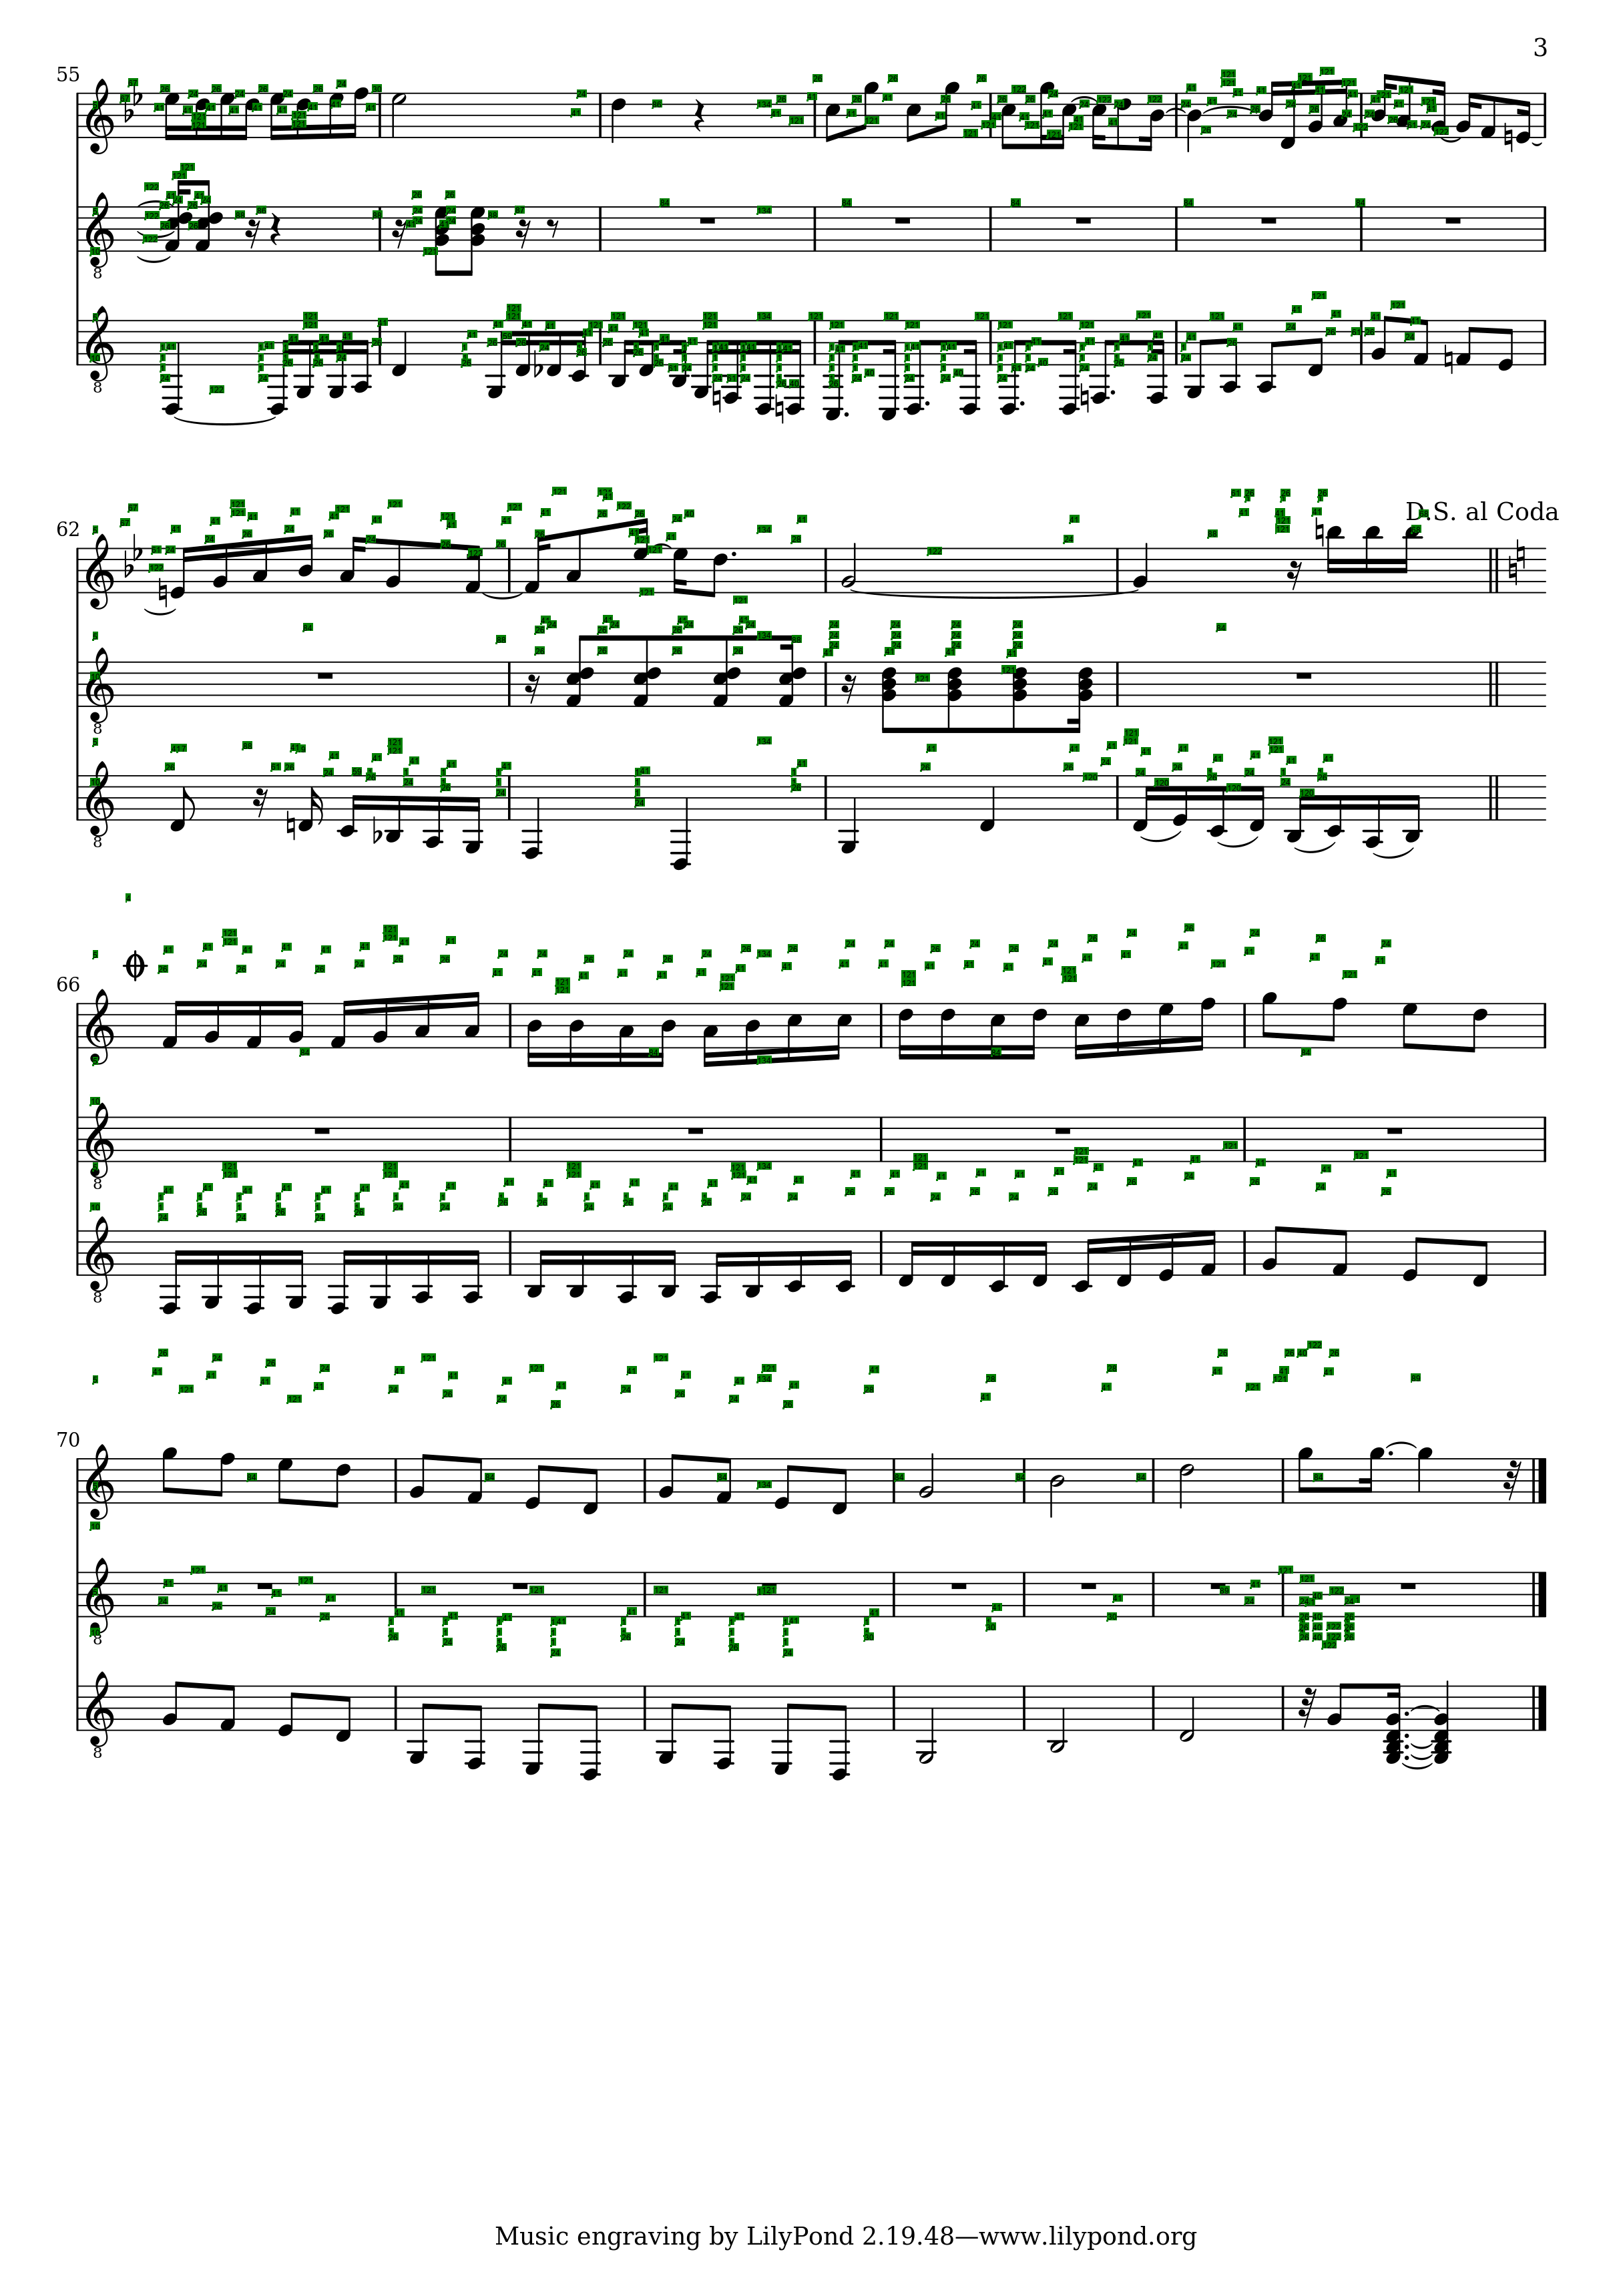

In [10]:
import config
rendered = draw_gt_image(gt_df, img_id=679, config=config)